# **Dependencies Install**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#**Skewness of Dataset**

In [ ]:
cnt = {}
# df = pd.read_csv('/content/drive/MyDrive/Projects/MTP Project/900_data - We_gpt.csv')
df = pd.read_csv('/content/Binary Dataset - Sheet1.csv')
df.head()

,Full Complaint,Complaint/Non Complaint
0,Accidentally I had a fracture in hip and admit...,0.0
1,We came from tagarapuvalasa we are happy to ta...,0.0
2,I came to this hospital for my implant removal...,0.0
3,Admited with a hip fracture staff support and ...,0.0
4,Admited here with a ligment break gone through...,0.0


In [ ]:
non_complaint = (df['Complaint/Non Complaint'] == 0).sum()

print("Total Dataset: ", len(df))
print(f"Number of Complaints are {len(df) - non_complaint}")
print(f"Number of non complaints are {non_complaint}")

Total Dataset:  2444
Number of Complaints are 1326
Number of non complaints are 1118


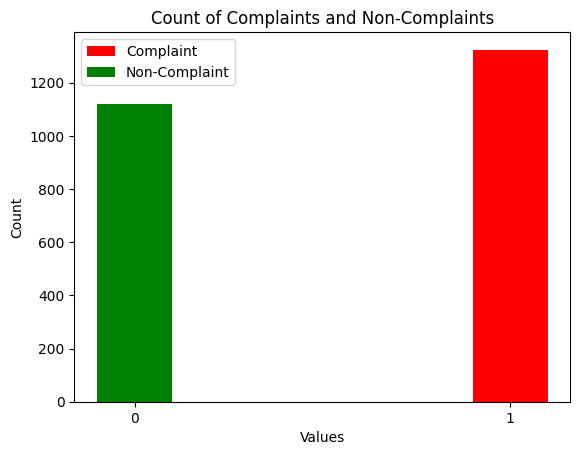

In [ ]:
value_counts = df['Complaint/Non Complaint'].value_counts()
bar_width =0.2
plt.bar(value_counts.index, value_counts.values, color=['Red', 'Green'], label=['Complaint', 'Non-Complaint'], width=bar_width)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of Complaints and Non-Complaints')
plt.xticks([0, 1])
plt.legend()
plt.show()

# **Number of words Analysis**

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')

def clean_and_count_words(text):
    tokens = word_tokenize(text)

    table = str.maketrans('', '', string.punctuation)
    words = [word.lower() for word in tokens if word.isalpha()]
    words = [word.translate(table) for word in words]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    word_count = len(words)

    return word_count



# Apply the clean_and_count_words function to the 'review' column
df['word_count'] = df['Full Complaint'].apply(clean_and_count_words)

# Display the DataFrame with word counts
print(df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                         Full Complaint  \
0     Accidentally I had a fracture in hip and admit...   
1     We came from tagarapuvalasa we are happy to ta...   
2     I came to this hospital for my implant removal...   
3     Admited with a hip fracture staff support and ...   
4     Admited here with a ligment break gone through...   
...                                                 ...   
2439  My dad is hospitalized in icu for pacemaker le...   
2440  I am shashikant, went for checkup of my wife i...   
2441  Wrongly treated by forties gurgaon & due to th...   
2442  Hi, \n  \n  On 11th may i suffered from vomiti...   
2443  Highly unprofessionally managed hospital.\n  \...   

      Complaint/Non Complaint  word_count  
0                         0.0          14  
1                         0.0          16  
2                         0.0          15  
3                         0.0          15  
4                         0.0          13  
...                       .

In [ ]:
short_reviews = df[df['word_count'] < 80]
short_reviews = short_reviews.reset_index(drop=True)
short_reviews.head()

,Full Complaint,Complaint/Non Complaint,word_count
0,Accidentally I had a fracture in hip and admit...,0.0,14
1,We came from tagarapuvalasa we are happy to ta...,0.0,16
2,I came to this hospital for my implant removal...,0.0,15
3,Admited with a hip fracture staff support and ...,0.0,15
4,Admited here with a ligment break gone through...,0.0,13


In [ ]:
non_complaint = (short_reviews['Complaint/Non Complaint'] == 0).sum()

print("Total Dataset: ", len(short_reviews))
print(f"Number of Complaints are {len(short_reviews) - non_complaint}")
print(f"Number of non complaints are {non_complaint}")

Total Dataset:  1997
Number of Complaints are 909
Number of non complaints are 1088


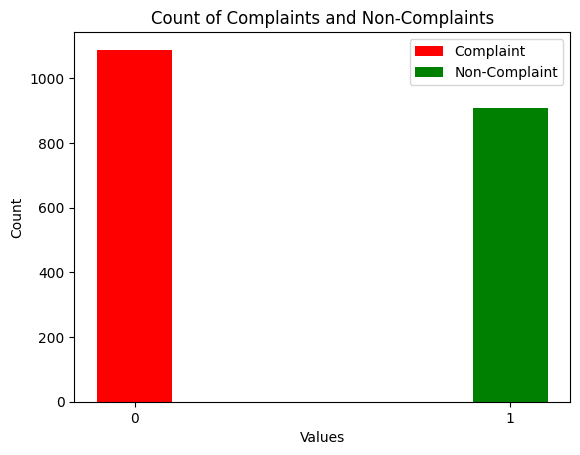

In [ ]:
value_counts = short_reviews['Complaint/Non Complaint'].value_counts()
bar_width =0.2
plt.bar(value_counts.index, value_counts.values, color=['Red', 'Green'], label=['Complaint', 'Non-Complaint'], width=bar_width)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of Complaints and Non-Complaints')
plt.xticks([0, 1])
plt.legend()
plt.show()

# **Google Gemini**

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import pathlib
import textwrap
import google.generativeai as genai
from google.colab import userdata
from IPython.display import display
from IPython.display import Markdown

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-pro
models/gemini-pro-vision


In [ ]:
model = genai.GenerativeModel('gemini-pro')

In [ ]:
non_comp = short_reviews[short_reviews['Complaint/Non Complaint']==0]
non_comp = non_comp.reset_index(drop=True)
print("Total number of Non Complaints :", len(non_comp))

Total number of Non Complaints : 1088


In [ ]:
non_comp['Full Complaint'][0]

'Accidentally I had a fracture in hip and admited here doctor and nursing staff are so good nice treatment I totally had a best experience in this hospital\n'

# **Zero Shot Binary Classification**

In [ ]:
prediction = []
i = 1

for review in short_reviews['Full Complaint']:
    try:
        prompt = f"""Your task is to classify text.

        Choose the label among the following possibilities with the highest probability.
        Only return the label, nothing more:

        'Complaint', 'Non-Complaint'

        For this task, consider the reviews apart from heathcare domain as indicative of 'Non-Complaint.'

        The text to classify:
        ```
        {review}
        ```

        Your response:
        """.strip()

        response = model.generate_content(prompt, stream=True)

        for chunk in response:
            prediction.append(chunk.text)
            print(i)
            print(chunk.text)
            print(10 * '-')
        i = i + 1

    except Exception as e:
        prediction.append('2')
        print(f"Error in iteration {i}: {str(e)}")
        # Optionally, you can add code here to handle or log the error


Streaming output truncated to the last 5000 lines.
Non-Complaint
----------
172
Non-Complaint
----------
173
Non-Complaint
----------
174
Non-Complaint
----------
175
Non-Complaint
----------
176
Non-complaint
----------
177
Non-Complaint
----------
178
Non-Complaint
----------
179
Non-Complaint
----------
180
Non-Complaint
----------
181
Non-Complaint
----------
182
Non-Complaint
----------
183
Non-Complaint
----------
184
Non-Complaint
----------
185
Non-Complaint
----------
186
Non-Complaint
----------
187
Non-Complaint
----------
188
Non-Complaint
----------
189
Non-Complaint
----------
190
Non-Complaint
----------
191
Non-Complaint
----------
192
Non-Complaint
----------
193
Non-Complaint
----------
194
Non-Complaint
----------
195
Non-Complaint
----------
196
Non-Complaint
----------
197
Non-Complaint
----------
198
Non-Complaint
----------
199
 tauttautautautautautautauta:ta:tas:tá:
----------
199
tautautau:tau:tauT:::::atautautau
----------
200
Non-Complaint
----------
201
Non-

In [ ]:
pre_result = []
for pre in prediction:
    if pre.lower() == 'complaint':
        pre_result.append(1)
    else:
        pre_result.append(0)

In [ ]:
len(pre_result)

In [ ]:
conf_matrix = confusion_matrix(short_reviews['Complaint/Non Complaint'], pre_result)
accuracy = accuracy_score(short_reviews['Complaint/Non Complaint'], pre_result)
precision = precision_score(short_reviews['Complaint/Non Complaint'], pre_result)
recall = recall_score(short_reviews['Complaint/Non Complaint'], pre_result)
f1 = f1_score(short_reviews['Complaint/Non Complaint'], pre_result)

# Display the confusion matrix and performance metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# **Few Shot Binary Classification**

In [ ]:
prediction = []
i=0
from tqdm.notebook import tqdm
for review in tqdm(short_reviews['Full Complaint']):
    # %%time
    device = "cuda:0"

    prompt = f"""<<SYS>>Your task is to classify text.

Choose the class among the following classes with the highest probability.
Only return the label in python list, nothing more:

### Classes:
1: 'Complaint'
0: 'Non-Complaint'
<</SYS>>[INST]### Text:
```
Dear Sir /madam,
I am a employee at EENADU journalism college and my wife is admitted at ESIC Nacharam, Hyderabad with a bone breakage in the right elbow on
Saturday evening 22/04/2023 and the condition of the hospital is worst everywhere human waste and employees not taking care of patients there is
no proper response from doctors and today is Wednesday but there is no progress can you please have look into the issue asap
```
[/INST]Label: 1</s><s>[INST]### Text:
```
Good morning sir we are living in chennai ramapuram here nearby miot hospital ramapuram road mgr house road there is one wine shop and
more than 20 infected dogs biting and barking everyone in evening 7to10 time people's get troubled and afraid to come that side kindly please
solve this issue. Women's and childrens were there already we get troubling by drunken guys
```
[/INST]Label : 0</s><s>[INST]### Text:
```
{review}
```
[/INST]Label: """.strip()

        response = model.generate_content(prompt, stream=True)

        for chunk in response:
            prediction_f.append(chunk.text)
            print(i)
            print(chunk.text)
            print(10 * '-')
        i = i + 1

    except Exception as e:
        prediction_f.append('2')
        print(f"Error in iteration {i}: {str(e)}")
        # Optionally, you can add code here to handle or log the error


In [ ]:
pre_result_f = []
for pre in prediction:
    if pre.lower() == 'complaint':
        pre_result_f.append(1)
    else:
        pre_result_f.append(0)

In [ ]:
len(pre_result_f)

In [ ]:
conf_matrix_f = confusion_matrix(short_reviews['Complaint/Non Complaint'], pre_result_f)
accuracy_f = accuracy_score(short_reviews['Complaint/Non Complaint'], pre_result_f)
precision_f = precision_score(short_reviews['Complaint/Non Complaint'], pre_result_f)
recall_f = recall_score(short_reviews['Complaint/Non Complaint'], pre_result_f)
f1_f = f1_score(short_reviews['Complaint/Non Complaint'], pre_result_f)

# Display the confusion matrix and performance metrics
print("Confusion Matrix:")
print(conf_matrix_f)
print("\nAccuracy:", accuracy_f)
print("Precision:", precision_f)
print("Recall:", recall_f)
print("F1 Score:", f1_f)

# **Prediction Analysis**

In [ ]:
short_reviews['Predictions'] = pre_results_f            # pre_results_f  for few shot, pre_results for zero shot

short_non_complaint = (short_reviews['Predictions'] == 0).sum()

print("Total Dataset: ", len(short_reviews))
print(f"Number of Complaints are {len(short_reviews) - short_non_complaint}")
print(f"Number of non complaints are {short_non_complaint}")

In [ ]:
#segregating only predicted complaints from the dataset

aspect_df = short_reviews[short_reviews['Predictions'] = 1]

# **Aspect class Zero Shot**

In [ ]:
aspect_pred = []
i = 1

for review in aspect_df['Full Complaint']:
    try:
        prompt = f"""Your task is to classify text.
        Choose one or more labels among the following possibilities with the highest probability.
        Only return the label(s), nothing more:

        'Billing', 'Negligence', 'Behaviour', 'Service', 'Time', 'Shortage', 'Accusation', 'Dispute', 'Dirty', 'Online', 'Pharmacy', 'Product'

        The text to classify:
        {review}

        Your response:
        """.strip()

        response = model.generate_content(prompt, stream=True)

        for chunk in response:
            aspect_pred.append(chunk.text)
            print(i)
            print(chunk.text)
            print(10 * '-')
        i = i + 1

    except Exception as e:
        aspect_pred.append('2')
        print(f"Error in iteration {i}: {str(e)}")
        # Optionally, you can add code here to handle or log the error


In [ ]:
#comp = 'hospital was not cleaned properly, staff was very rude, machines were not in working condition, medicines were not available'

In [ ]:
# try:
#   prompt = f"""
#       ###Instruction###
#       You are a text classifier for healthcare domain, you are expert in classify the text.
#       Classify the text given to you in one or more most relevant Aspect classes, but not more than 6 classes,
#       your response must have most relevant Aspect classes in a list using comma as a delimiter,
#       do not give any explanation or any note, only return the python list containing relevant Aspect classes.

#             ### Aspect Classes ###
#             1. 'Billing'
#             2. 'Negligence'
#             3. 'Behaviour'
#             4. 'Service'
#             5. 'Time'
#             6. 'Shortage'
#             7. 'Accusation'
#             8. 'Dispute'
#             9. 'Dirty'
#             10. 'Online'
#             11. 'Pharmacy'
#             12. 'Product'

#       ###Find Aspect classes for below text###
#       {comp}

#       Your response:[
#       """.strip()

#   response = model.generate_content(prompt, stream=True)

#   for chunk in response:
#       print(chunk.text)
#       print(10 * '-')

# except Exception as e:
#   print(f"Error in iteration: {str(e)}")
#   # Optionally, you can add code here to handle or log the error

['Dirty', 'Behaviour', 'Service', 'Shortage']
----------


# **Aspect class few Shot**

In [ ]:
aspect_pred_f = []
i = 1

for review in aspect_df['Full Complaint']:
    try:
        prompt = f"""Your task is to classify text.
        Choose one or more labels among the following possibilities with the highest probability.
        Only return the label(s), nothing more:

        'Billing', 'Negligence', 'Behaviour', 'Service', 'Time', 'Shortage', 'Accusation', 'Dispute', 'Dirty', 'Online', 'Pharmacy', 'Product'


        For Example:

        <Example> : I have booked a diagnostic service on Netmeds.com on Sept ** Order ID=DIAG************* and paid *** rupees from my netbanking which was debited but the order didinot created or acknowledge thorugh email or sms. No one even bothered to call for the service not provided for the lab. Also, despite of repeated emails and ** calls still didnot got refund for same. Please check and help to get my money back. Thanks
        <Your Response> : [Billing]

        <Example> : In the initial conversation with Dr. Amrutha on a video call I particularly asked about IPR where I was told that toothsi aligners are easy like wearing a specs. However after the payment was done I was told about IPR. Now I am in my last trimester of my pregnancy and suffering from perforation as there is a hole in my ear drum, which needs to be operated post my delivery. I am asking for the refund but they are denying and disconnecting my calls. They are literally harassing me mentally.
        <Your Response> : [Billing, Service]

        <Example> : I have ordered my protein whey *.* kg on dated **/**/****. And still my product not dispatched from their stores. I had tried to contact more than ** times through calls and mails but their reply was not satisfactory at all. Now they have stopped attending my mails. This is very pathetic service by my protein India
        <Your Response> : [Time, Behaviour]

        <Example> : Dear sir, I have placed order on Medi*all.Com.Order #MA****** and MA****** was placed on July **, **** but my order not delivered.i had made payment through credit card. Order related to infant formula milk similar advance stage *.I need my order on urgent basis. They are not dispatching my order nor refund my money.. I am unable to communicate them. They are not over contact number Or email address. How are these people even trading. Terrible service. Not respond over email and contact. Please do the needful as soon as possible
        <Your Response> : [Online, Time]


        The text to classify:
        ```
        {review}
        ```

        Your response: [
        """.strip()

        response = model.generate_content(prompt, stream=True)

        for chunk in response:
            aspect_pred_f.append(chunk.text)
            print(i)
            print(chunk.text)
            print(10 * '-')
        i = i + 1

    except Exception as e:
        aspect_pred_f.append('2')
        print(f"Error in iteration {i}: {str(e)}")
        # Optionally, you can add code here to handle or log the error